# 1.4b: Cosine Distribution Analysis

This notebook visualizes the distribution of cosine similarities to the cluster reference direction.

## The Question

We found 2,251 tokens with cosine = 0.84375 to the reference direction (the cluster). But what does the full distribution look like?

We'll examine:
1. **Rank plot**: Tokens sorted by cosine, showing the S-curve of projection geometry
2. **Histogram**: Distribution of cosine values, revealing where tokens pile up

This reveals the "visual acuity" of the model when looking in this direction—where small angular differences matter, and where they don't.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Visualization
FIGSIZE = (14, 6)
DPI = 200

# Histogram bins
N_BINS = 100

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Cluster Results

We'll load the cosine values computed in 1.4a, but we need to recompute them for all tokens (1.4a only saved the cluster members).

In [3]:
# Load cluster metadata
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4a_cluster_members.safetensors")
cluster_data = load_file(cluster_path)

cluster_mask = cluster_data["cluster_mask"].bool()
cluster_cosine = cluster_data["cluster_cosine"].item()
n_cluster = cluster_data["n_cluster_members"].item()
ref_lat = cluster_data["ref_lat"].item()
ref_lon = cluster_data["ref_lon"].item()

print(f"Loaded cluster metadata:")
print(f"  Reference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°")
print(f"  Cluster size: {n_cluster:,} tokens")
print(f"  Cluster cosine: {cluster_cosine:.8f}")

Loaded cluster metadata:
  Reference: lat=-7.288°, lon=6.941°
  Cluster size: 2,251 tokens
  Cluster cosine: 0.84375000


## Recompute All Cosines

We need to recompute cosines for all tokens to visualize the full distribution.

In [4]:
print("\nRecomputing cosines for all tokens...\n")

# Detect device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# Load W
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]
N, d = W_bf16.shape

# Convert to float32 for PCA
W = W_bf16.to(torch.float32)

# Compute PCA (same as 1.4a)
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, idx]

# Define basis (same as 1.4a)
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

# Convert lat/long to direction
lat_rad = np.deg2rad(ref_lat)
lon_rad = np.deg2rad(ref_lon)

x = np.cos(lat_rad) * np.cos(lon_rad)
y = np.cos(lat_rad) * np.sin(lon_rad)
z = np.sin(lat_rad)

ref_direction = x * meridian + y * equinox + z * north
ref_direction = ref_direction / ref_direction.norm()

# Compute cosines in bfloat16
ref_bf16 = ref_direction.to(torch.bfloat16).to(device)
W_bf16_device = W_bf16.to(device)
W_norm_bf16 = W_bf16_device / W_bf16_device.norm(dim=1, keepdim=True)

with torch.no_grad():
    cosines_bf16 = W_norm_bf16 @ ref_bf16

cosines = cosines_bf16.to(torch.float32).cpu().numpy()

print(f"✓ Computed cosines for {N:,} tokens")
print(f"  Range: [{cosines.min():.6f}, {cosines.max():.6f}]")
print(f"  Mean: {cosines.mean():.6f}")
print(f"  Median: {np.median(cosines):.6f}")


Recomputing cosines for all tokens...

✓ Computed cosines for 151,936 tokens
  Range: [-0.683594, 0.847656]
  Mean: 0.240467
  Median: 0.236328


## Rank Plot: Sorted Cosines

This shows the S-curve of cosine values when tokens are sorted by rank.


Creating rank plot...



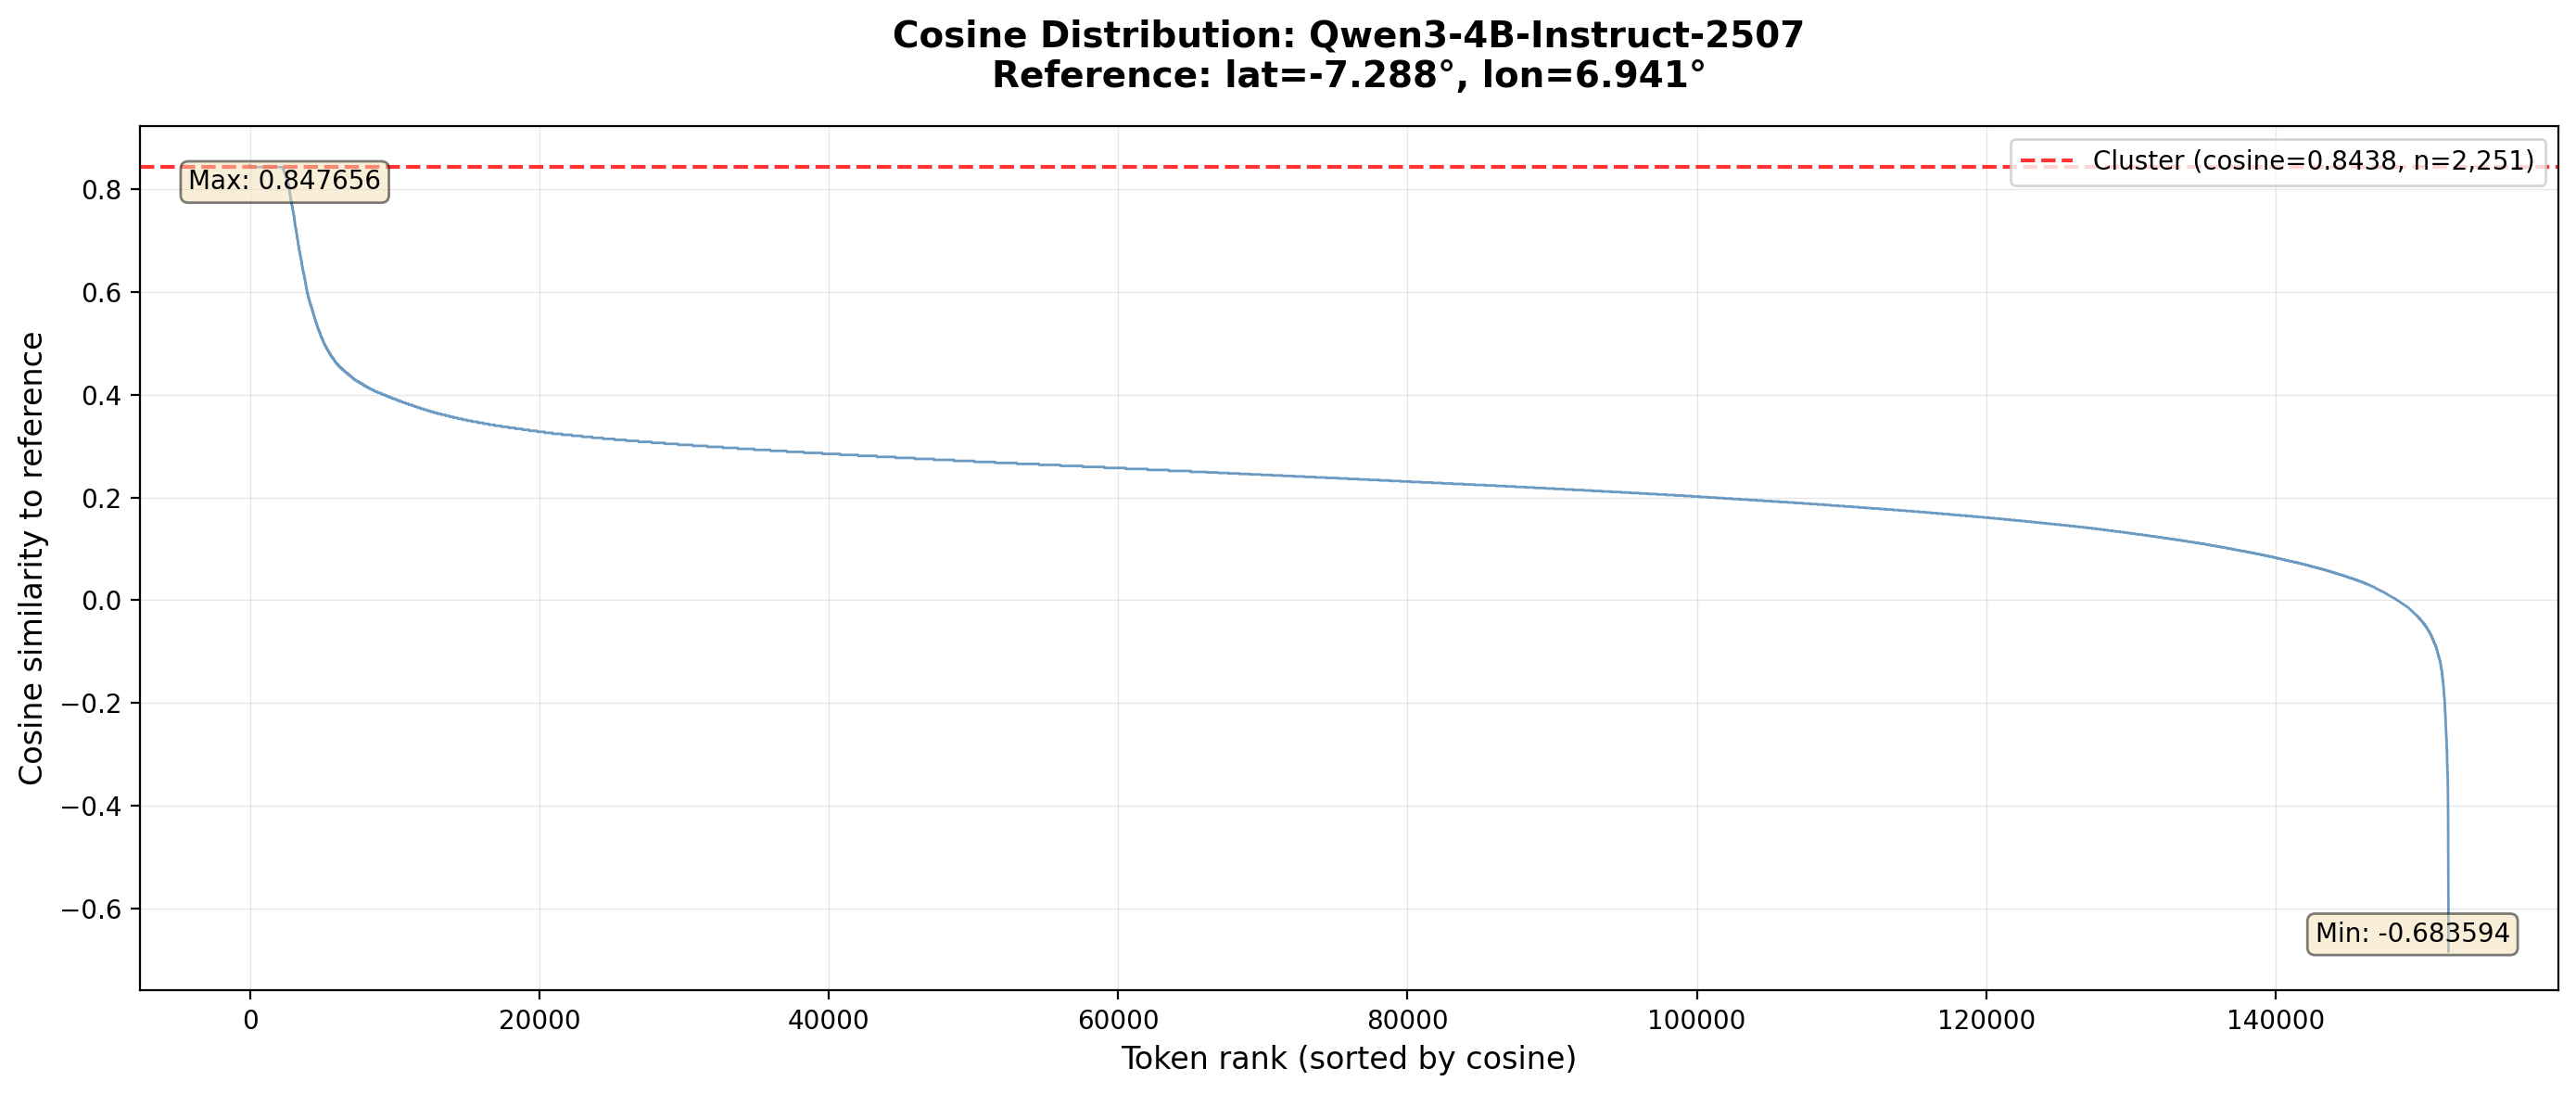

✓ Rank plot complete


In [8]:
print("\nCreating rank plot...\n")

# Sort cosines (descending)
sorted_cosines = np.sort(cosines)[::-1]
ranks = np.arange(N)

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Plot sorted cosines
ax.plot(ranks, sorted_cosines, linewidth=1, color='steelblue', alpha=0.8)

# Highlight cluster cosine
ax.axhline(cluster_cosine, color='red', linestyle='--', linewidth=1.5, 
           label=f'Cluster (cosine={cluster_cosine:.4f}, n={n_cluster:,})', alpha=0.8)

# Formatting
ax.set_xlabel('Token rank (sorted by cosine)', fontsize=12)
ax.set_ylabel('Cosine similarity to reference', fontsize=12)
ax.set_title(f'Cosine Distribution: {MODEL_NAME}\nReference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.legend(loc='upper right', fontsize=10)

# Add annotations for key regions
ax.text(0.02, 0.95, f'Max: {sorted_cosines[0]:.6f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.text(0.98, 0.05, f'Min: {sorted_cosines[-1]:.6f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ax.set_xlim(0, 5000)

plt.tight_layout()
plt.show()

print("✓ Rank plot complete")

## Histogram: Cosine Value Distribution

This shows where tokens pile up in cosine space.


Creating histogram...



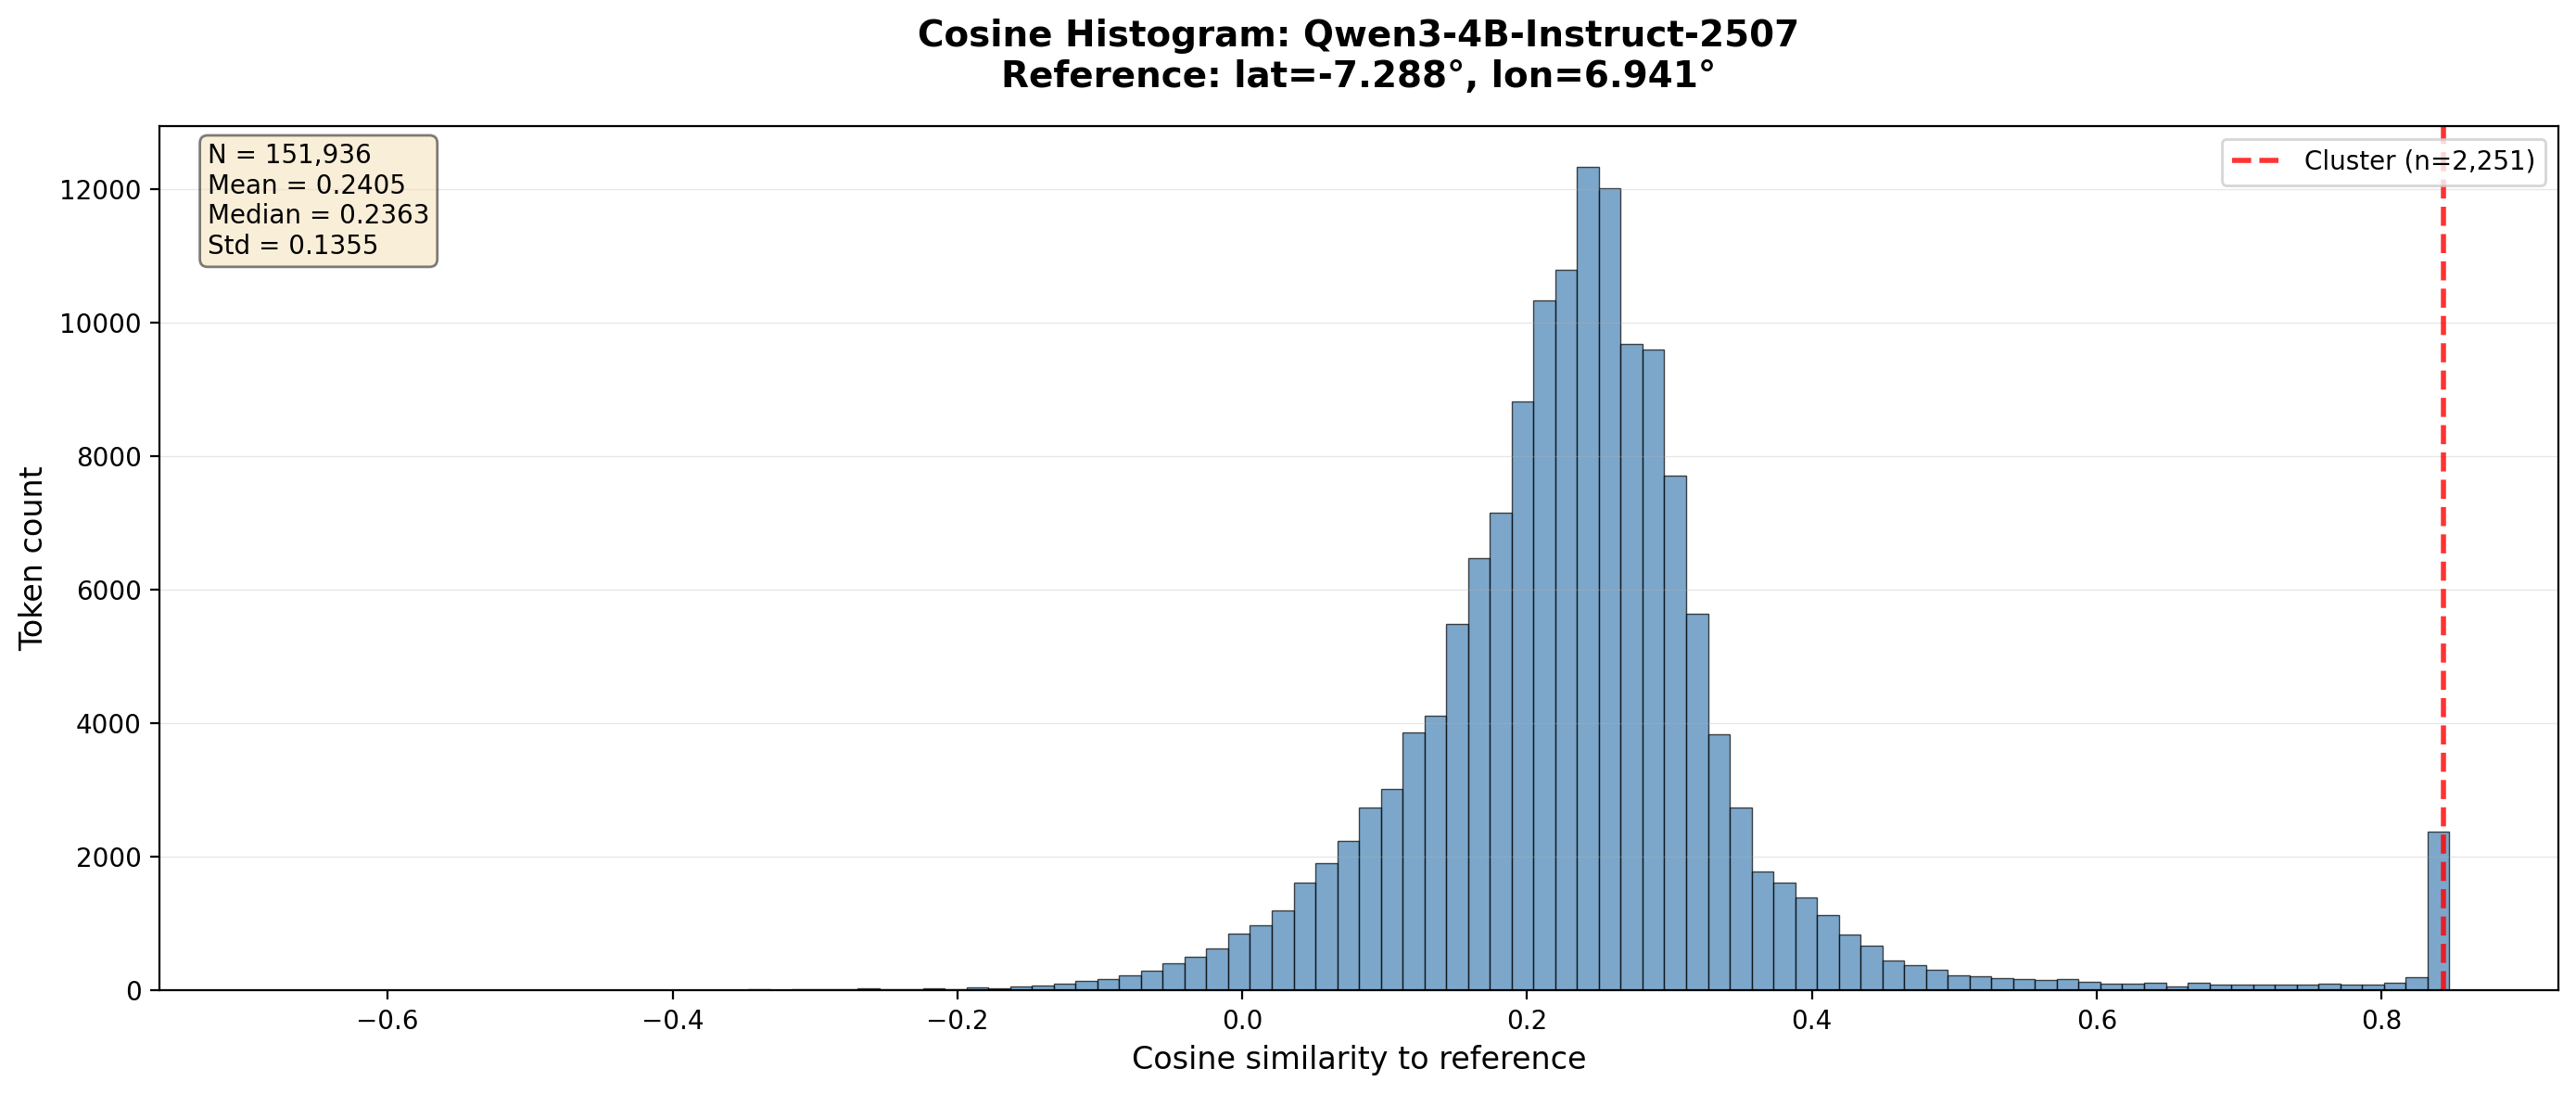

✓ Histogram complete


In [9]:
print("\nCreating histogram...\n")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Plot histogram
counts, bins, patches = ax.hist(cosines, bins=N_BINS, color='steelblue', 
                                 alpha=0.7, edgecolor='black', linewidth=0.5)

# Highlight cluster cosine
ax.axvline(cluster_cosine, color='red', linestyle='--', linewidth=2,
           label=f'Cluster (n={n_cluster:,})', alpha=0.8)

# Formatting
ax.set_xlabel('Cosine similarity to reference', fontsize=12)
ax.set_ylabel('Token count', fontsize=12)
ax.set_title(f'Cosine Histogram: {MODEL_NAME}\nReference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linewidth=0.5, axis='y')
ax.legend(loc='upper right', fontsize=10)

# Add statistics
stats_text = f"N = {N:,}\nMean = {cosines.mean():.4f}\nMedian = {np.median(cosines):.4f}\nStd = {cosines.std():.4f}"
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Unique Cosine Values

How many distinct cosine values exist at bfloat16 precision?

In [10]:
print("\nAnalyzing unique cosine values...\n")

unique_cosines, counts = np.unique(cosines, return_counts=True)
n_unique = len(unique_cosines)

print(f"Total unique cosine values: {n_unique:,} ({n_unique/N*100:.2f}% of vocabulary)")
print()

# Distribution of degeneracy (how many tokens share each cosine)
print("Degeneracy distribution:")
print(f"  Singletons (1 token): {np.sum(counts == 1):,}")
print(f"  Pairs (2 tokens): {np.sum(counts == 2):,}")
print(f"  Triplets (3 tokens): {np.sum(counts == 3):,}")
print(f"  4+ tokens: {np.sum(counts >= 4):,}")
print()

# Most degenerate values
sorted_indices = np.argsort(counts)[::-1]
top_n = 10

print(f"Top {top_n} most degenerate cosine values:")
for i in range(top_n):
    idx = sorted_indices[i]
    cosine_val = unique_cosines[idx]
    count = counts[idx]
    cluster_flag = "← CLUSTER" if abs(cosine_val - cluster_cosine) < 1e-6 else ""
    print(f"  {i+1}. cosine={cosine_val:.8f}: {count:,} tokens {cluster_flag}")


Analyzing unique cosine values...

Total unique cosine values: 2,113 (1.39% of vocabulary)

Degeneracy distribution:
  Singletons (1 token): 461
  Pairs (2 tokens): 232
  Triplets (3 tokens): 189
  4+ tokens: 1,231

Top 10 most degenerate cosine values:
  1. cosine=0.84375000: 2,251 tokens ← CLUSTER
  2. cosine=0.26171875: 1,539 tokens 
  3. cosine=0.26562500: 1,528 tokens 
  4. cosine=0.25195312: 1,517 tokens 
  5. cosine=0.25585938: 1,517 tokens 
  6. cosine=0.26757812: 1,507 tokens 
  7. cosine=0.25976562: 1,492 tokens 
  8. cosine=0.26367188: 1,479 tokens 
  9. cosine=0.25781250: 1,470 tokens 
  10. cosine=0.25390625: 1,469 tokens 


## Summary

The rank plot shows the S-curve of projection geometry:
- **Steep at extremes**: Few tokens highly aligned or anti-aligned
- **Shallow in middle**: Many tokens pile up near orthogonal (cosine ≈ 0)

The cluster at cosine = 0.84375 is an **anomalous spike**—far more tokens than expected at such high alignment.

The histogram reveals where "visual acuity" is high (steep regions) vs low (flat regions where small angular changes don't matter).